# Parameters

In [20]:
TRACEFILE = "./MsgTraces_W5_load-90p_0.tr"

In [21]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
messages_allsizes: List[int] = []

with open(TRACEFILE, "r") as f:
    for line in f:
        log = line.split()
        ts = float(log[1]) * 1e-9   # seconds
        sz = int(log[2])            # bytes
        sender = log[3]             # ip:port
        receiver = log[4]             # ip:port
        txid = int(log[5])

        key = Message.get_key(sender, receiver, txid)

        if log[0] == "+":
            msg = Message(sender, receiver, txid, sz)
            msg.start_ts = ts
            messages[key].append(msg)
        elif log[0] == "-":
            msg = next((m for m in messages[key] if m.end_ts == 0), None)
            if not msg:
                print("ERROR: cannot find start entry for ", line)
                continue
            
            if msg.end_ts:
                print("Message already has an end_ts!", msg)
                continue
            
            msg.end_ts = ts
            messages_allsizes.append(msg.sz)
            messages_size2delays[msg.sz].append(msg.completion_time)

all_messages_list = []
for msgs in list(messages.values()):
    all_messages_list.extend(msgs)

In [22]:
# for msg in all_messages_list:
#     print(msg)

In [23]:

import numpy as np
from scipy import stats

allMsgSizes = np.array(messages_allsizes)
msg_size_percentiles = stats.rankdata(allMsgSizes, "max")/len(allMsgSizes) * 100


In [24]:
# some basic statistics

print("Total number of messages:", len(all_messages_list))
print("Total number of distinct message sizes:", len(messages_size2delays))

num_incomplete = len([msg for msg in all_messages_list if msg.end_ts == 0])
print("Number of incomplete messages: %s" % num_incomplete)

# sorted_sizes = sorted(messages_size2delays.keys())
# for i, sz in enumerate(sorted_sizes):
#     if i == 0:
#         print(sz)
#     else:
#         print(f"{sz} +{sz - sorted_sizes[i - 1]}")


Total number of messages: 174
Total number of distinct message sizes: 71
Number of incomplete messages: 54


In [25]:
import matplotlib.pyplot as plt


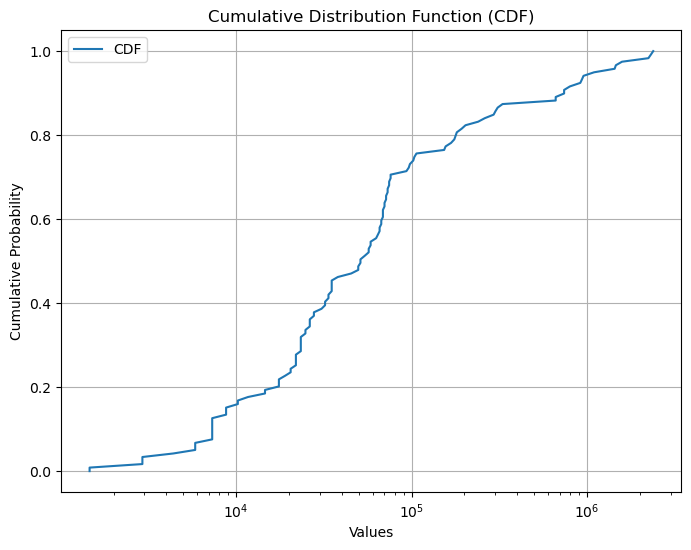

In [26]:
# basic CDF of message sizes

# Sorting the data
sorted_data = np.sort(messages_allsizes)

# Calculating the cumulative distribution
cdf = np.linspace(0, 1, len(sorted_data))

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, label='CDF')

plt.xscale("log")

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

msg_sz=21900 msg_delays=[2.1017999999983772e-05, 2.1079999999784604e-05, 2.2219999999961715e-05, 1.9715999999725398e-05]
msg_sz=73000 msg_delays=[6.285100000003041e-05, 6.443500000008484e-05]
msg_sz=1460 msg_delays=[4.001999999836414e-06, 5.613999999987129e-06]
msg_sz=58400 msg_delays=[5.0841000000190206e-05, 5.2226000000210604e-05]
msg_sz=14600 msg_delays=[1.4810999999781416e-05, 1.5108000000374489e-05]
msg_sz=26280 msg_delays=[2.4418999999831215e-05, 2.505100000016469e-05, 2.4792000000051218e-05]
msg_sz=32120 msg_delays=[2.9223000000300203e-05, 2.9740000000000322e-05]
msg_sz=5840 msg_delays=[7.824000000322684e-06, 6.504999999989991e-06, 8.118999999862098e-06]
msg_sz=74460 msg_delays=[6.566900000004594e-05, 0.00015968999999982358]
msg_sz=178120 msg_delays=[0.0001493230000000345]
msg_sz=93440 msg_delays=[7.966499999989551e-05]
msg_sz=175200 msg_delays=[0.0001458209999998239]
msg_sz=70080 msg_delays=[6.0449000000240005e-05, 0.0001080500000001372]
msg_sz=30660 msg_delays=[2.8021999999960

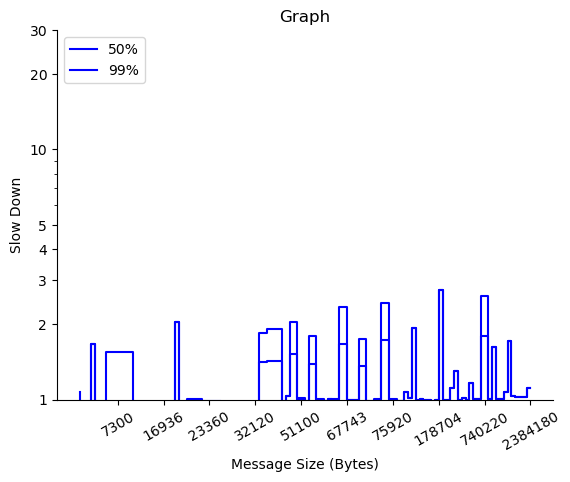

In [27]:
# this time, we calculate the *SLOWDOWN*.

import math

PACKET_PAYLOAD_SIZE_BYTES = 1460
PACKET_HEADER_SIZE_BYTES = 40
PACKET_SIZE = PACKET_PAYLOAD_SIZE_BYTES + PACKET_HEADER_SIZE_BYTES
TOR_BANDWIDTH = 10e9
SPINE_BANDWIDTH = 40e9

# how the fuck are these numbers derived?
ONE_WAY_DELAY = 1.0e-6 + PACKET_SIZE * 8 * (2 / TOR_BANDWIDTH + 2 / SPINE_BANDWIDTH)
BASE_RTT = ONE_WAY_DELAY + 1.0e-6 + 64 * 8 * (2 / TOR_BANDWIDTH + 2 / SPINE_BANDWIDTH)

BDP_PACKETS = 7

messages_size2slowdown_p99: Dict[int, float] = defaultdict(float)

SimMsgSizes = []
SimP50CompletionTimes = []
SimP99CompletionTimes = []
SimBaseCompletionTimes = []
SimP50SlowDowns = []
SimP99SlowDowns = []


for msg_sz, msg_delays in messages_size2delays.items():
    print(f"{msg_sz=} {msg_delays=}")

    SimMsgSizes.append(msg_sz)

    delays = np.array(msg_delays)
    p50_delay = np.percentile(delays, 50)
    SimP50CompletionTimes.append(p50_delay)
    p99_delay = np.percentile(delays, 99)
    SimP99CompletionTimes.append(p99_delay)

    npackets = math.ceil(msg_sz / PACKET_PAYLOAD_SIZE_BYTES)
    nbytes = msg_sz + PACKET_HEADER_SIZE_BYTES * npackets

    base_delay = nbytes * 8/ TOR_BANDWIDTH + ONE_WAY_DELAY

    SimBaseCompletionTimes.append(base_delay)

    p50_slowdown = p50_delay / base_delay
    p99_slowdown = p99_delay / base_delay

    messages_size2slowdown_p99[msg_sz] = p99_slowdown
    SimP50SlowDowns.append(p50_slowdown)
    SimP99SlowDowns.append(p99_slowdown)

###
zipData = sorted(zip(SimMsgSizes,
                      SimP50CompletionTimes,
                      SimP99CompletionTimes,
                      SimBaseCompletionTimes,
                      SimP50SlowDowns,
                      SimP99SlowDowns))

SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])

SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])

SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])

SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

window_size = 10

x = [msg_size_percentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes]
plt.step(x, SimP50SlowDowns, label="50%", color="blue")
plt.step(x, SimP99SlowDowns, label="99%", color="red")

plt.ylabel("Slow Down")
plt.xlabel("Message Size (Bytes)")
plt.title("Graph")
plt.legend(loc="upper left")

xTickPercentiles = np.linspace(10, 100, 10)
xticks = np.percentile(allMsgSizes, xTickPercentiles).astype(int)
plt.xticks(xTickPercentiles, xticks, rotation=30)

plt.yscale('log')
yticks = [1,2,3,4,5,10, 20, 30]
plt.ylim([1,30])
plt.yticks(yticks, yticks)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.show()


###

# msg_sz = sorted(messages_size2slowdown_p99.keys())
# msg_p99slowdown = [messages_size2slowdown_p99[sz] for sz in msg_sz]

# # Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.step(msg_sz, msg_p99slowdown, linestyle='-', color='blue')

# # Set labels and title
# plt.xlabel('Message Sizes')
# plt.ylabel('P99 Delays')
# plt.title('Scatter Plot of P99 Delays vs Message Sizes')

# # Show grid
# plt.grid(True)

# # Show the plot
# plt.show()